## 1.0 Import Library

In [348]:
import pandas as pd
import datetime

## 1.1 Load Dataset

In [349]:
df = pd.read_csv("../data/interim/df_complete.csv", parse_dates=['transaction_date'])

In [350]:
df['mnth_yr'] = df['transaction_date'].apply(lambda x: x.strftime('%B-%Y')) 
df['mnth'] = df['transaction_date'].dt.month
df.head(1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398321 entries, 0 to 398320
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   user_id                       398321 non-null  object        
 1   transaction_date              398321 non-null  datetime64[ns]
 2   amount_n26_currency           398321 non-null  int64         
 3   explanation_mcc               398321 non-null  object        
 4   direction                     398321 non-null  object        
 5   agent                         398321 non-null  object        
 6   explanation_transaction_type  251591 non-null  object        
 7   customer_trx_key              398321 non-null  object        
 8   mnth_yr                       398321 non-null  object        
 9   mnth                          398321 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 30.4+ MB


In [351]:
dfx = df.groupby(['user_id','direction','mnth_yr', 'mnth']).agg(amount = ('amount_n26_currency','sum'), num_trx = ('amount_n26_currency','count')).reset_index()
dfx.head()

,user_id,direction,mnth_yr,mnth,amount,num_trx
0,000295594379774ab9ac2c78c946d615,In,February-2016,2,291,1
1,000295594379774ab9ac2c78c946d615,In,June-2016,6,115,1
2,000295594379774ab9ac2c78c946d615,In,March-2016,3,381,1
3,000295594379774ab9ac2c78c946d615,In,May-2016,5,155,1
4,000295594379774ab9ac2c78c946d615,Out,February-2016,2,280,1


## Remove customer with just 1 month amount

In [352]:
test = dfx.groupby(['user_id','direction'])['mnth_yr'].nunique().reset_index()
dfx = dfx[~dfx.user_id.isin(test[test.mnth_yr == 1]['user_id']) ]

## 2.0 Exploratory Data Analysis

In [353]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [354]:
check_df(dfx)

##################### Shape #####################
(66823, 6)
##################### Types #####################
user_id      object
direction    object
mnth_yr      object
mnth          int64
amount        int64
num_trx       int64
dtype: object
##################### Head #####################
                            user_id direction        mnth_yr  mnth  amount  \
0  000295594379774ab9ac2c78c946d615        In  February-2016     2     291   
1  000295594379774ab9ac2c78c946d615        In      June-2016     6     115   
2  000295594379774ab9ac2c78c946d615        In     March-2016     3     381   

   num_trx  
0        1  
1        1  
2        1  
##################### Tail #####################
                                user_id direction     mnth_yr  mnth  amount  \
73296  fffde1ba10b4040deb651162f56c9fc4       Out   June-2016     6     217   
73297  fffde1ba10b4040deb651162f56c9fc4       Out  March-2016     3     345   
73298  fffde1ba10b4040deb651162f56c9fc4       Out    Ma

TBF

## 3.0 Outlier Check

For outlier detection, I will use IQR method with Q1 as 0.05% and Q3 as 0.95%. I will compute the low limit and up limit with IQR method and check if the sales variable contain values above/below these limits. It will return boolean.
For outlier detection, I will use IQR method with Q1 as 0.05% and Q3 as 0.95%. I will compute the low limit and up limit with IQR method and check if the sales variable contain values above/below these limits. It will return boolean.

In [355]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [356]:
check_outlier(dfx, 'amount')

True

In [357]:
dfx.groupby(["user_id","direction"]).agg({"amount": ["sum", "mean", "median", "std"]})

amount                     \
                                              sum        mean median   
user_id                          direction                             
000295594379774ab9ac2c78c946d615 In           942  235.500000  223.0   
                                 Out          902  180.400000  154.0   
000aa792d73dd82b16a29692772d395a In           815  407.500000  407.5   
                                 Out          706  117.666667   90.5   
0011103fe4ba1264342882b7ab98c641 In          2083  520.750000  486.0   
...                                           ...         ...    ...   
fff9eec15875baad3df433c8780aa3bd Out          924  154.000000  124.5   
fffd503ed2ecb63067b7369f4d668aed In          1342  223.666667  213.5   
                                 Out          816  136.000000  130.5   
fffde1ba10b4040deb651162f56c9fc4 In          2815  563.000000  239.0   
                                 Out         2696  449.333333  276.5   

                                                        
                                                   std  
user_id                          direction              
000295594379774ab9ac2c78c946d615 In         122.815580  
                                 Out        155.709024  
000aa792d73dd82b16a29692772d395a In         357.088924  
                                 Out         99.369345  
0011103fe4ba1264342882b7ab98c641 In         369.670461  
...                                                ...  
fff9eec15875baad3df433c8780aa3bd Out        129.358417  
fffd503ed2ecb63067b7369f4d668aed In          81.433818  
                                 Out        108.815440  
fffde1ba10b4040deb651162f56c9fc4 In         547.691519  
                                 Out        561.432691  

[14746 rows x 4 columns]

## 4.0 Feature Engg

In order to search for seasonalities, date variable will be used to derive new features and different time periods will be created.In order to search for seasonalities, date variable will be used to derive new features and different time periods will be created.

In [358]:
# def create_date_features(df):
#     df['month'] = df.date.dt.month
#     df['quarter'] = df.date.dt.day
#     df['day_of_year'] = df.date.dt.dayofyear
#     df['week_of_year'] = df.date.dt.weekofyear
#     # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
#     df['day_of_week'] = df.date.dt.dayofweek + 1
#     df['year'] = df.date.dt.year
#     df["is_wknd"] = df.date.dt.weekday // 4
#     df['is_month_start'] = df.date.dt.is_month_start.astype(int)
#     df['is_month_end'] = df.date.dt.is_month_end.astype(int)
#     return df

def create_num_days_month(m):
    if m==2:
        return 28
    list = [1,3,5,7,8,10,12]
    if m in list:
        return 31
    return 30

In [359]:
dfx["num_days_month"] = dfx['mnth'].apply(lambda x: create_num_days_month(x))

# df.rename(columns= {'transaction_date':'date'}, inplace= True)
# df = create_date_features(df)
dfx.head()

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month
0,000295594379774ab9ac2c78c946d615,In,February-2016,2,291,1,28
1,000295594379774ab9ac2c78c946d615,In,June-2016,6,115,1,30
2,000295594379774ab9ac2c78c946d615,In,March-2016,3,381,1,31
3,000295594379774ab9ac2c78c946d615,In,May-2016,5,155,1,31
4,000295594379774ab9ac2c78c946d615,Out,February-2016,2,280,1,28


## 4.1 Add Random noise

For small datasets like this one, in order to avoid overfitting, random noise can be added to the values. I will add Gaussian random noise which is normally distributed with a standard deviation of 1 and mean of 0.

In [360]:
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

## 4.2 Lag/Shifted Features
Time Series theory states that, the value in time: t highly depends on the value in time: t-1. That is why I will be shifting all the sales values by 1 and adding noise.

In [361]:
# sort the values per store, item and date so that values would be shifted equally

dfx.sort_values(by=['user_id','direction', 'mnth'], axis=0, inplace=True)

In [362]:
dfx

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month
0,000295594379774ab9ac2c78c946d615,In,February-2016,2,291,1,28
2,000295594379774ab9ac2c78c946d615,In,March-2016,3,381,1,31
3,000295594379774ab9ac2c78c946d615,In,May-2016,5,155,1,31
1,000295594379774ab9ac2c78c946d615,In,June-2016,6,115,1,30
4,000295594379774ab9ac2c78c946d615,Out,February-2016,2,280,1,28
...,...,...,...,...,...,...,...
73297,fffde1ba10b4040deb651162f56c9fc4,Out,March-2016,3,345,10,31
73293,fffde1ba10b4040deb651162f56c9fc4,Out,April-2016,4,199,7,30
73298,fffde1ba10b4040deb651162f56c9fc4,Out,May-2016,5,336,13,31
73296,fffde1ba10b4040deb651162f56c9fc4,Out,June-2016,6,217,12,30


In [366]:
# the feature name will be created dynamically with regards to the lag value for a given list of lags

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['amount_lag_' + str(lag)] = dataframe.groupby(['user_id','direction'])['amount'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [367]:
dfx = lag_features(dfx, [1, 2, 3])

In [368]:
dfx.head()

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month,amount_lag_1,amount_lag_2,amount_lag_3
0,000295594379774ab9ac2c78c946d615,In,February-2016,2,291,1,28,NaN,NaN,NaN
2,000295594379774ab9ac2c78c946d615,In,March-2016,3,381,1,31,291.660543,NaN,NaN
3,000295594379774ab9ac2c78c946d615,In,May-2016,5,155,1,31,378.601355,292.263377,NaN
1,000295594379774ab9ac2c78c946d615,In,June-2016,6,115,1,30,154.397210,382.029493,291.704973
4,000295594379774ab9ac2c78c946d615,Out,February-2016,2,280,1,28,NaN,NaN,NaN


## 4.2 Rolling Mean / Moving Average

In order to find out possible seasonalities, I will be creating moving averagesfor specified time intervals. This function takes the number of time given as window parameter and takes the average of the values, but one of the values is the value on this specific observation. In order to eliminate today's affect on moving average values, I will take 1 shift and use this function

In [371]:
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['amount_roll_mean_' + str(window)] = dataframe.groupby(['user_id','direction'])['amount']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=2, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [372]:
dfx = roll_mean_features(dfx, [2,3,4])
dfx.head()

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month,amount_lag_1,amount_lag_2,amount_lag_3,amount_roll_mean_2,amount_roll_mean_3,amount_roll_mean_4
0,000295594379774ab9ac2c78c946d615,In,February-2016,2,291,1,28,NaN,NaN,NaN,NaN,NaN,NaN
2,000295594379774ab9ac2c78c946d615,In,March-2016,3,381,1,31,291.660543,NaN,NaN,NaN,NaN,NaN
3,000295594379774ab9ac2c78c946d615,In,May-2016,5,155,1,31,378.601355,292.263377,NaN,336.055059,322.170046,312.605640
1,000295594379774ab9ac2c78c946d615,In,June-2016,6,115,1,30,154.397210,382.029493,291.704973,267.629257,301.346699,310.081315
4,000295594379774ab9ac2c78c946d615,Out,February-2016,2,280,1,28,NaN,NaN,NaN,NaN,NaN,NaN


## 3.5.4.Exponentially Weighted Mean Features  

The value in time t highly depends on the value in time t-1, so in order to have a better prediction, while computing the average value, the values should not be equally weighted.<a id="section-nine"></a>


In [373]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['amount_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["user_id", "direction"])['amount']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [374]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1, 2, 3]

In [375]:
dfx = ewm_features(dfx, alphas, lags)
dfx.tail()

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month,amount_lag_1,amount_lag_2,amount_lag_3,...,amount_ewm_alpha_09_lag_3,amount_ewm_alpha_08_lag_1,amount_ewm_alpha_08_lag_2,amount_ewm_alpha_08_lag_3,amount_ewm_alpha_07_lag_1,amount_ewm_alpha_07_lag_2,amount_ewm_alpha_07_lag_3,amount_ewm_alpha_05_lag_1,amount_ewm_alpha_05_lag_2,amount_ewm_alpha_05_lag_3
73297,fffde1ba10b4040deb651162f56c9fc4,Out,March-2016,3,345,10,31,26.909522,NaN,NaN,...,NaN,28.000000,NaN,NaN,28.000000,NaN,NaN,28.000000,NaN,NaN
73293,fffde1ba10b4040deb651162f56c9fc4,Out,April-2016,4,199,7,30,346.126280,27.030005,NaN,...,NaN,292.166667,28.000000,NaN,271.846154,28.000000,NaN,239.333333,28.000000,NaN
73298,fffde1ba10b4040deb651162f56c9fc4,Out,May-2016,5,336,13,31,199.530962,345.155959,27.056442,...,28.000000,217.032258,292.166667,28.000000,219.438849,271.846154,28.000000,216.285714,239.333333,28.000000
73296,fffde1ba10b4040deb651162f56c9fc4,Out,June-2016,6,217,12,30,334.801019,197.761378,344.540707,...,316.181818,312.358974,217.032258,292.166667,301.697953,219.438849,271.846154,280.133333,216.285714,239.333333
73295,fffde1ba10b4040deb651162f56c9fc4,Out,July-2016,7,1571,18,31,217.919250,337.194220,198.086320,...,210.612613,236.047375,312.358974,217.032258,242.264964,301.697953,219.438849,247.548387,280.133333,216.285714


In [376]:
dfx['amount'] = np.log1p(dfx["amount"].values)
# df['sales'].head() 

In [377]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [380]:
train = dfx.loc[(dfx["mnth"] < 7), :]
# train["date"].min(), train["date"].max()

In [381]:
val = dfx.loc[(dfx["mnth"] == 7) , :]

In [382]:
val.head(2)

,user_id,direction,mnth_yr,mnth,amount,num_trx,num_days_month,amount_lag_1,amount_lag_2,amount_lag_3,...,amount_ewm_alpha_09_lag_3,amount_ewm_alpha_08_lag_1,amount_ewm_alpha_08_lag_2,amount_ewm_alpha_08_lag_3,amount_ewm_alpha_07_lag_1,amount_ewm_alpha_07_lag_2,amount_ewm_alpha_07_lag_3,amount_ewm_alpha_05_lag_1,amount_ewm_alpha_05_lag_2,amount_ewm_alpha_05_lag_3
5,000295594379774ab9ac2c78c946d615,Out,July-2016,7,2.302585,1,31,68.136757,155.459204,390.898438,...,380.909091,93.49359,196.290323,372.5,110.762174,213.309353,365.384615,148.133333,239.714286,354.0
9,000aa792d73dd82b16a29692772d395a,In,July-2016,7,5.049856,1,31,660.177724,NaN,NaN,...,NaN,660.00000,NaN,NaN,660.000000,NaN,NaN,660.000000,NaN,NaN


In [383]:
cols = [col for col in train.columns if col not in ['user_id', "direction", "mnth","mnth_yr","amount","num_trx"]]

In [384]:
Y_train = train['amount']
X_train = train[cols]

Y_val = val['amount']
X_val = val[cols]

In [385]:
import lightgbm as lgb
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [386]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [387]:
type(lgbtrain)

lightgbm.basic.Dataset

In [388]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012360 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.898945	training's SMAPE: 76.2956	valid_1's l1: 0.803926	valid_1's SMAPE: 69.1249
[400]	training's l1: 0.894571	training's SMAPE: 75.952	valid_1's l1: 0.799608	valid_1's SMAPE: 68.6627
[600]	training's l1: 0.892112	training's SMAPE: 75.7846	valid_1's l1: 0.799338	valid_1's SMAPE: 68.6149
[800]	training's l1: 0.889924	training's SMAPE: 75.6404	valid_1's l1: 0.79912	valid_1's SMAPE: 68.5739
[1000]	training's l1: 0.887814	training's SMAPE: 75.5004	valid_1's l1: 0.79937	valid_1's SMAPE: 68.5905
Early stopping, best iteration is:
[831]	training's l1: 0.889587	training's SMAPE: 75.6188	valid_1's l1: 0.799042	valid_1's SMAPE: 68.5649


In [389]:
y_pred_val = model.predict(X_val)

In [390]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

68.56489986157786

In [391]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(np.expm1(y_pred_val), np.expm1(Y_val)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mean_absolute_percentage_error(np.expm1(y_pred_val), np.expm1(Y_val)))    

106353.12654616861
102.86431287876812


In [392]:
def plot_lgb_importances(model,plot=True,num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    print(feat_imp.head(num))

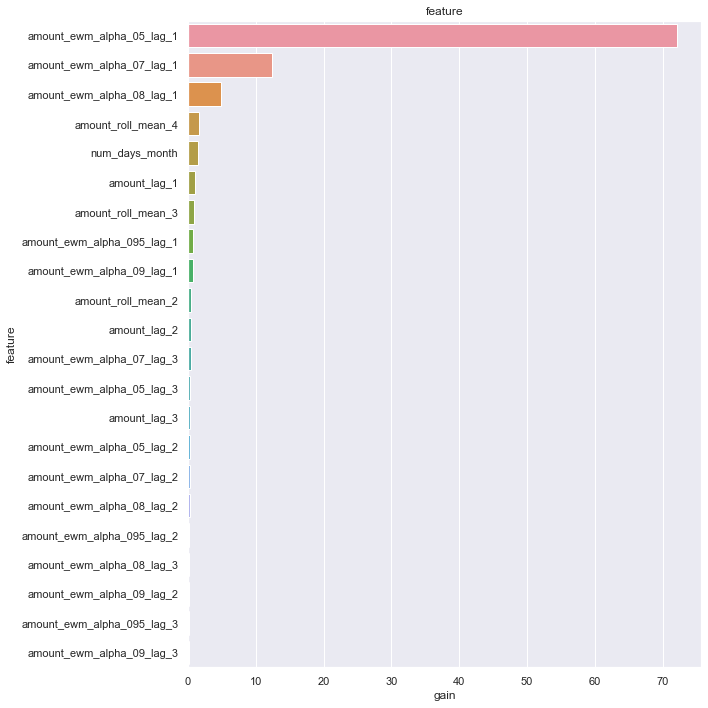

feature  split       gain
19   amount_ewm_alpha_05_lag_1    705  72.051815
16   amount_ewm_alpha_07_lag_1    333  12.433446
13   amount_ewm_alpha_08_lag_1    267   4.866797
6           amount_roll_mean_4    474   1.692272
0               num_days_month    412   1.537741
1                 amount_lag_1    615   1.042306
5           amount_roll_mean_3    351   0.916704
7   amount_ewm_alpha_095_lag_1    264   0.726862
10   amount_ewm_alpha_09_lag_1    247   0.718728
4           amount_roll_mean_2    456   0.532013


In [393]:
plot_lgb_importances(model,30)

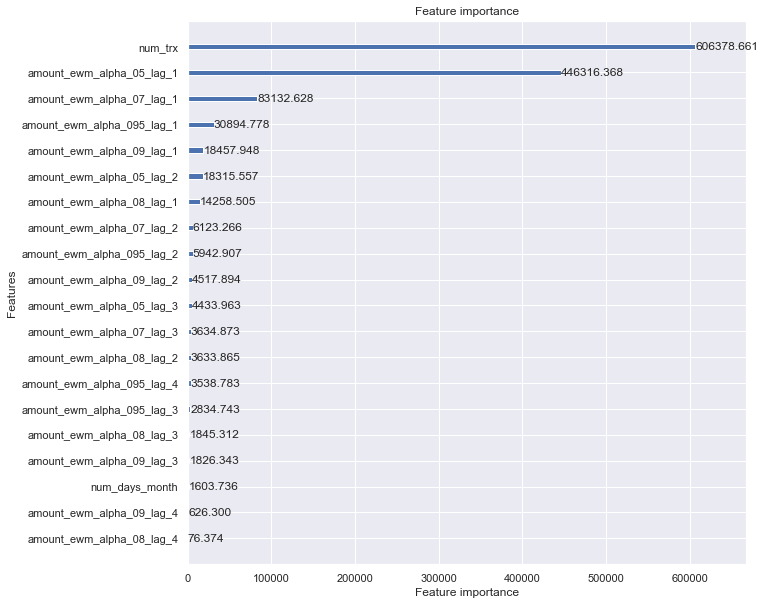

In [317]:
# this one is the built-in plot function of LightGBM library

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [398]:
np.expm1(y_pred_val).shape

(11104,)

In [ ]:
data = {"students": students,
        "subject": subject,
        "marks": marks}
  

In [399]:
np.expm1(Y_val).shape

(11104,)

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}